In [10]:
import numpy as np
import sklearn as sk
import pandas as pd
import matplotlib.pyplot as plt
import re

import nltk
from collections import Counter
from nltk import ne_chunk, pos_tag, word_tokenize
from nltk.tree import Tree
from nltk.chunk import conlltags2tree, tree2conlltags
from pprint import pprint

from sklearn.feature_extraction import DictVectorizer

from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.decomposition import LatentDirichletAllocation

Define basic functions

In [4]:
def get_continuous_chunks(text):
    chunked = ne_chunk(pos_tag(word_tokenize(text)))
    prev = None
    continuous_chunk = []
    current_chunk = []
    for i in chunked:
            if type(i) == Tree:
                    current_chunk.append(" ".join([token for token, pos in i.leaves()]))
            elif current_chunk:
                    named_entity = " ".join(current_chunk)
                    if named_entity not in continuous_chunk:
                            continuous_chunk.append(named_entity)
                            current_chunk = []
            else:
                    continue
    return continuous_chunk

def num_named_entity(text):
    named_entity = np.array(get_continuous_chunks(text))
    return named_entity.shape[0]

def num_sen(X):
    sentences = len(X.split("."))
    return sentences

def num_word(X):
    words = len(X.split())
    return words

def avg_word_per_sen(X):
    word_per_sen = num_word(X)/num_sen(X)
    return word_per_sen

def frac_words(X):    
    num_of_sen = np.array(X.split(".")).shape[0]
    
    #tokenize using NLTK
    tokens = nltk.word_tokenize(X)
    text = nltk.Text(tokens)
    tags = nltk.pos_tag(text)
    
    #count words and nouns and normalize by total counts
    counts = Counter(tag for word,tag in tags)
    total = sum(counts.values())
    frac = dict((word, float(count)/total) for word,count in counts.items())
    
    #frac_noun: fraction of nouns
    noun_tags = ["NN","NNS","NNP","NNPS","PRP","PRP$","WP","WP$","WRB"]
    frac_noun = 0
    for tag_i in noun_tags:
        if tag_i in frac:
            frac_noun += frac[str(tag_i)]
            
    #frac_verb: fraction of verbs
    verb_tags = ["RB","RBR","RBS","VB","VBD","VBG","VBN","VBP","VBZ"]
    frac_verb = 0
    for tag_i in verb_tags:
        if tag_i in frac:
            frac_verb += frac[str(tag_i)]
    
    return np.array([[frac_noun, frac_verb]])

Define functions to compute polarity score

In [5]:
analyser = SentimentIntensityAnalyzer()

def polarity_score_by_sentence(text):    
    sentence_list = text.split(".")
    pscore_list = pd.DataFrame(index = range(1,num_sen(text)+1),columns=['neg','neu', 'pos', 'compound'])

    for i in range(num_sen(text)):
        pscore = analyser.polarity_scores(sentence_list[i])
        pscore_list.loc[i+1,:] = pscore
    return pscore_list

def avg_polarity_score(text):    
    pscore_list = polarity_score_by_sentence(text)
    return np.array(pscore_list.mean())

def var_polarity_score(text):    
    pscore_list = polarity_score_by_sentence(text)
    return np.array(pscore_list.var())
    
def polarity_scores(text):    
    pscore_list = polarity_score_by_sentence(text)
    
    return np.append(pscore_list.mean(),pscore_list.var())

Define functions to apply functions to the DataFrame

In [14]:
def make_stylo_features(X):
    Y = np.array([[num_sen(X),num_word(X), avg_word_per_sen(X), num_named_entity(X)]])
    Y = np.concatenate((Y,frac_words(X),polarity_scores(X)), axis=None)
    
    Y = pd.DataFrame(np.array([Y]), columns= ["num_sen","num_word", "avg_word_per_sen", "num_named_entity","frac_words_noun","frac_words_verb",
                    "avg_polarity_score_negative","avg_polarity_score_neutral","avg_polarity_score_positive","avg_polarity_score_compound",
                    "var_polarity_score_negative","var_polarity_score_neutral","var_polarity_score_positive","var_polarity_score_compound"])  
    return Y

def make_stylo_features_df_Text(data):
    stylo_features = make_stylo_features(data.loc[0,"Text"])
    for i in range(1,data.shape[0]):
        X = data.loc[i,"Text"]
        stylo_features = pd.concat([stylo_features,make_stylo_features(X)], axis=0, ignore_index=True)
    return stylo_features

def make_stylo_features_df_Title(data):
    stylo_features = make_stylo_features(data.loc[0,"Title"])
    for i in range(1,data.shape[0]):
        X = data.loc[i,"Title"]
        stylo_features = pd.concat([stylo_features,make_stylo_features(X)], axis=0, ignore_index=True)
    return stylo_features

def add_stylo_features(data):
    stylo_features = make_stylo_features(data.loc[0,"Text"])
    for i in range(1,data.shape[0]):
        X = data.loc[i,"Text"]
        stylo_features = pd.concat([stylo_features,make_stylo_features(X)], axis=0, ignore_index=True)
    data = pd.concat([data,stylo_features], axis=1)
    return data

def make_simple_stylo_features(X):
    Y = np.array([[num_sen(X),num_word(X), avg_word_per_sen(X)]])
    Y = pd.DataFrame(Y, columns= ["num_sen","num_word", "avg_word_per_sen"])  
    return Y

def make_simple_stylo_features_df(data):
    stylo_features = make_simple_stylo_features(data.loc[0,"Title"])
    for i in range(1,data.shape[0]):
        X = data.loc[i,"Title"]
        stylo_features = pd.concat([stylo_features,make_simple_stylo_features(X)], axis=0, ignore_index=True)
    return stylo_features

Load data from csv files

In [8]:
articles_df = pd.read_csv("data/HealthMap - extracted outbreak articles.csv")
df_ken = pd.read_csv("data/ken.csv")
df_cal = pd.read_csv("data/cal.csv")

articles_df.head()

,Location,Title,link,Issue date,Category,Mention other states? (yes - 1/no - 0),States if 1 in F
0,"Alabama, United States",Hepatitis A outbreak investigation spreads to ...,http://www.waff.com/2018/12/29/hepatitis-outbr...,12/28/18 22:39,Breaking,0.0,NaN
1,"Alabama, United States","PRO/EDR> Hepatitis A - USA (65): (KY, WV, AL)",http://promedmail.org/direct.php?id=20181229.6...,12/29/18 17:46,No Tag,1.0,"KY, WV"
2,"Alabama, United States",Health Officials Warn About Increasing Outbrea...,https://dailybusinessgazette.com/health-offici...,12/30/18 7:18,Breaking,1.0,TN
3,"Alabama, United States",Hepatitis A outbreak spreads - rocketcitynow.com,https://www.rocketcitynow.com/news/hepatitis-a...,1/10/19 7:08,Breaking,0.0,NaN
4,"Alabama, United States","Hepatitis A outbreak in Georgia, Alabama - WRBL",https://www.wrbl.com/news/georgia/hepatitis-a-...,3/18/19 14:05,Context,1.0,GA


Sentiment analysis 1

Data: the titles of all articles - with outbreak vs. without outbreak

In [18]:
df_appended = pd.read_csv('HealthMap_stylo_data_added.csv')

df_states = pd.read_csv("data/List of states with outbreak_no outbreak.csv")
df_states.columns = ['State','Outbreak']
df_states.head()

,State,Outbreak
0,Alabama,0
1,Alaska,0
2,Arizona,0
3,Arkansas,1
4,California,1


In [19]:
stylo_data = make_stylo_features_df_Title(articles_df)
stylo = stylo_data[["num_named_entity","avg_polarity_score_negative","avg_polarity_score_neutral","avg_polarity_score_positive","avg_polarity_score_compound"]]
df_appended = pd.concat([articles_df, stylo], axis = 1)

df_appended.Location = df_appended.Location.str.extract(r'(.*?,)')
df_appended.Location = df_appended.Location.str.rstrip(',')
df_appended

df_no = df_appended[df_appended.Location.isin(df_states.State[df_states.Outbreak == 0])]
df_yes = df_appended[df_appended.Location.isin(df_states.State[df_states.Outbreak == 1])]
df_nyc = df_appended[~df_appended.Location.isin(df_states.State)]
df_no = pd.concat([df_no, df_nyc])

df_no.head()

,Location,Title,link,Issue date,Category,Mention other states? (yes - 1/no - 0),States if 1 in F,num_named_entity,avg_polarity_score_negative,avg_polarity_score_neutral,avg_polarity_score_positive,avg_polarity_score_compound
0,Alabama,Hepatitis A outbreak investigation spreads to ...,http://www.waff.com/2018/12/29/hepatitis-outbr...,12/28/18 22:39,Breaking,0.0,NaN,1.0,0.000,1.000,0.0,0.0000
1,Alabama,"PRO/EDR> Hepatitis A - USA (65): (KY, WV, AL)",http://promedmail.org/direct.php?id=20181229.6...,12/29/18 17:46,No Tag,1.0,"KY, WV",4.0,0.000,1.000,0.0,0.0000
2,Alabama,Health Officials Warn About Increasing Outbrea...,https://dailybusinessgazette.com/health-offici...,12/30/18 7:18,Breaking,1.0,TN,3.0,0.104,0.896,0.0,-0.1027
3,Alabama,Hepatitis A outbreak spreads - rocketcitynow.com,https://www.rocketcitynow.com/news/hepatitis-a...,1/10/19 7:08,Breaking,0.0,NaN,0.0,0.000,1.000,0.0,0.0000
4,Alabama,"Hepatitis A outbreak in Georgia, Alabama - WRBL",https://www.wrbl.com/news/georgia/hepatitis-a-...,3/18/19 14:05,Context,1.0,GA,2.0,0.000,1.000,0.0,0.0000


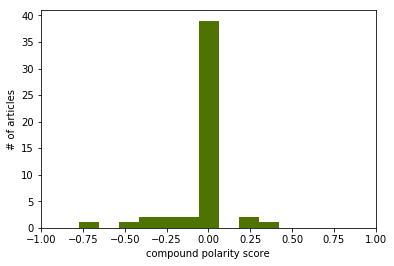

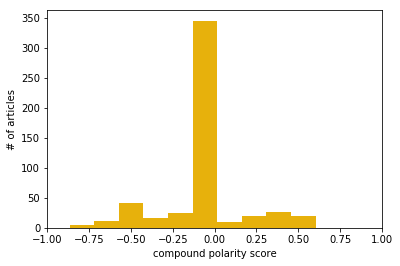

In [20]:
plt.hist(df_no['avg_polarity_score_compound'], color="#4F7301")
# plt.title("Histogram of the polarity score: compound, NO Outbreak")
plt.xlim(-1,1)
plt.xlabel("compound polarity score")
plt.ylabel("# of articles")

plt.show()

plt.hist(df_yes['avg_polarity_score_compound'], color="#E7B10C")
# plt.title("Histogram of the polarity score: compound, YES Outbreak")
plt.xlim(-1,1)
plt.xlabel("compound polarity score")
plt.ylabel("# of articles")

plt.show()

Sentiment analysis 2

Data: the titles of all articles - four different polarity scores

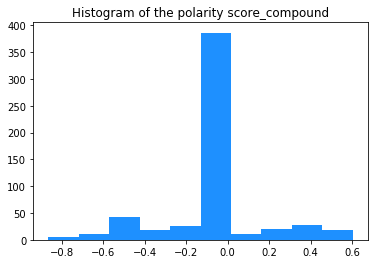

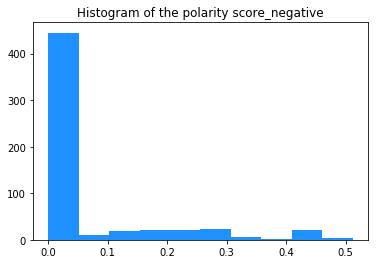

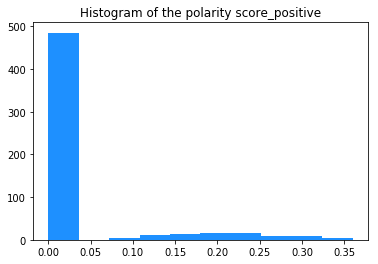

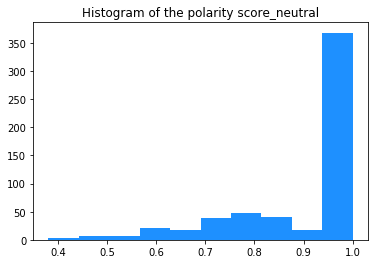

In [37]:
plt.hist(df_appended['avg_polarity_score_compound'], color = "dodgerblue")
plt.title("Histogram of the polarity score_compound")
plt.show()

plt.hist(df_appended['avg_polarity_score_negative'], color = "dodgerblue")
plt.title("Histogram of the polarity score_negative")
plt.show()

plt.hist(df_appended['avg_polarity_score_positive'], color = "dodgerblue")
plt.title("Histogram of the polarity score_positive")
plt.show()

plt.hist(df_appended['avg_polarity_score_neutral'], color = "dodgerblue")
plt.title("Histogram of the polarity score_neutral")
plt.show()

Sentiment analysis 3

Data: the contents of articles form CA and KY - four different polarity scores

In [24]:
df_ken = add_stylo_features(df_ken)
df_cal = add_stylo_features(df_cal)

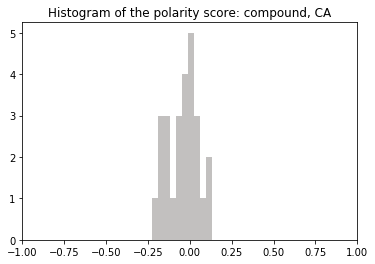

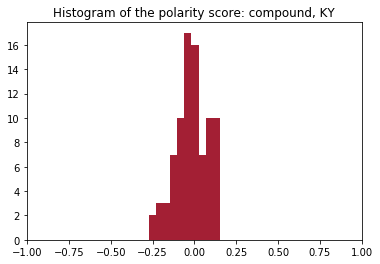

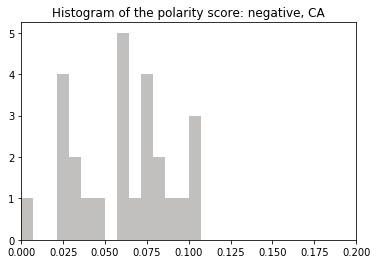

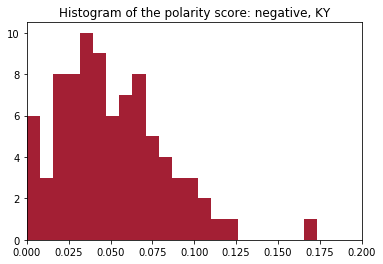

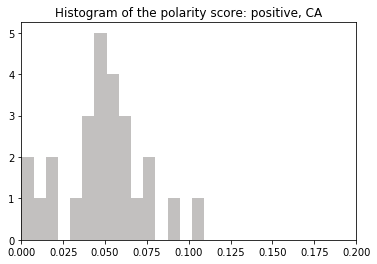

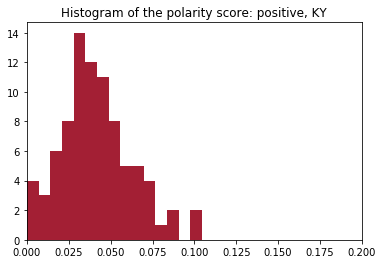

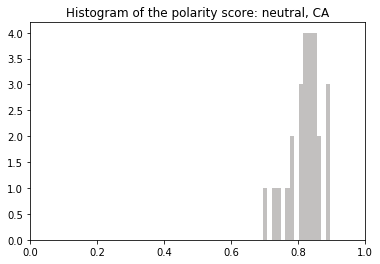

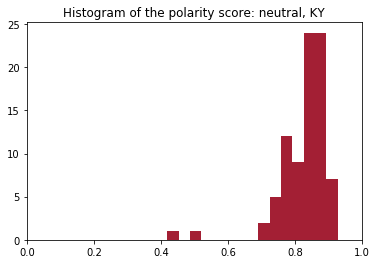

In [32]:
plt.hist(df_cal['avg_polarity_score_compound'], color="#C2C0BF")
plt.title("Histogram of the polarity score: compound, CA")
plt.xlim(-1,1)
plt.show()

plt.hist(df_ken['avg_polarity_score_compound'], color="#A31F34")
plt.title("Histogram of the polarity score: compound, KY")
plt.xlim(-1,1)
plt.show()



plt.hist(df_cal['avg_polarity_score_negative'], 15, color="#C2C0BF")
plt.title("Histogram of the polarity score: negative, CA")
plt.xlim(0,0.2)
plt.show()

plt.hist(df_ken['avg_polarity_score_negative'], 22, color="#A31F34")
plt.title("Histogram of the polarity score: negative, KY")
plt.xlim(0,0.2)
plt.show()



plt.hist(df_cal['avg_polarity_score_positive'], 15, color="#C2C0BF")
plt.title("Histogram of the polarity score: positive, CA")
plt.xlim(0,0.2)
plt.show()

plt.hist(df_ken['avg_polarity_score_positive'], 15, color="#A31F34")
plt.title("Histogram of the polarity score: positive, KY")
plt.xlim(0,0.2)
plt.show()



plt.hist(df_cal['avg_polarity_score_neutral'], 15, color="#C2C0BF")
plt.title("Histogram of the polarity score: neutral, CA")
plt.xlim(0,1)
plt.show()

plt.hist(df_ken['avg_polarity_score_neutral'], 15, color="#A31F34")
plt.title("Histogram of the polarity score: neutral, KY")
plt.xlim(0,1)
plt.show()

